In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import nltk
import gensim.downloader
import re
from calendar import day_name, day_abbr, month_name, month_abbr
from collections import Counter

from sklearn import preprocessing
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

NUM = '~NUM~'
DATE = '~DATE~'
URL = '~URL~'
PAD = '~PAD~'
UNK = '~UNK~'

date_regex = '('        + '|'.join(day_name[i] for i in range(7)) +\
             '|'        + '|'.join(day_abbr[i] for i in range(7)) +\
             ')?,?\s?(' + '|'.join(month_name[i] for i in range(1, 13)) +\
             '|'        + '|'.join(month_abbr[i] for i in range(1, 13)) +\
             ")\s[0-9]{1,2}(st|nd|rd|th)?(,?\s'?[0-9]{2,4})?"
url_regex = '(www\.|http://|https://)\S+|\S+\.(co|org|net|info|be|gov|edu|html|jpg|jpeg|png|gif)'

stopwords = nltk.corpus.stopwords.words('english')

PERCENT_VAL = 0.1
TEST_SIZE = 1000

RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)

In [3]:
%%time
EMBED_SIZE = 300
google300 = gensim.downloader.load('word2vec-google-news-300')
S = Counter()
C = Counter()
for word in google300.vocab:
    lower = word.lower()
    if lower in stopwords: continue
    S[lower] += google300[word]
    C[lower] += 1
google300 = {w: s / c for w, s, c in zip(S.keys(), S.values(), C.values())}

CPU times: user 1min 1s, sys: 4.03 s, total: 1min 5s
Wall time: 1min 7s


In [4]:
news = pd.read_csv('fake-news/train.csv')
news = news.dropna()
news = news[['title','text','label']]
news = news.sample(frac=1, random_state=RANDOM_SEED)

In [5]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(news.label)
y_te = y[:TEST_SIZE]
y = y[TEST_SIZE:]

trval = news.iloc[TEST_SIZE:]
trval = trval.copy(deep=True)
te = news.iloc[:TEST_SIZE]
te = te.copy(deep=True)

tr_size = int((1 - PERCENT_VAL) * len(trval))
tr = trval.iloc[:tr_size]
val = trval.iloc[tr_size:]

print(len(tr[tr.label==0]), len(tr[tr.label==1]))
print(len(val[val.label==0]), len(val[val.label==1]))
print(len(te[te.label==0]), len(te[te.label==1]))

8820 6736
990 739
551 449


In [6]:
%%time
def split_by_case(s):
    if (not s[1:].isupper()) and (not s[1:].islower()):
        for i in range(1,len(s)-1):
            if s[i-1].islower() and s[i].isupper():
                return [s[:i]] + split_by_case(s[i:])
            elif s[i].islower() and s[i+1].isupper():
                return [s[:i+1]] + split_by_case(s[i+1:])
    return [s]

def supertokenize(txt):
    txt = re.sub(date_regex, DATE, re.sub(url_regex, URL, txt))
    tokens = nltk.word_tokenize(txt)
    y = []
    for t in tokens:
        if t in '!"\'(),--./:;<?[\\]{|}“”‘’—': continue
        t = t.lower()
        if t != "n't": t = re.sub('["\']','',t)
        if t in stopwords: continue
        if t == URL:
            y.append(URL)
            continue
        if (re.sub('^[0-9]+(/[0-9]+)+$','',t) == '') or (t == DATE):
            y.append(DATE)
            continue
        if t.isnumeric() or (t[:-2].isnumeric() and (t[-2:] in ['st','nd'])):
            y.append(NUM)
            continue
        if t in google300:
            y.append(t)
        else:
            if t.replace('.', '') in google300:
                y.append(t.replace('.', ''))
                continue
            is_found = False
            for x in split_by_case(re.sub('[^a-z]','',t)):
                if x in google300:
                    y.append(x)
                    is_found = True
            if is_found: continue
            for st in re.split('-',re.sub('[^a-z0-9\.~]','-',t)):
                for x in [st, st[:-1], st[1:], st.replace('s','z'),
                          st.replace('ou','o'), st.replace('re','er')]:
                    if x in google300:
                        y.append(x)
                        is_found = True
                        break
            if not is_found: y.append(UNK)
    return y

def supertokenizeplus(x, lab):
    global wc_all, wc_fake, wc_real
    
    y = supertokenize(x)
    
    wc_all += Counter(y)
    
    c = Counter()
    for a in y: c[a] = 1
    if lab == 1:
        wc_fake += c
    else:
        wc_real += c
    
    return y

wc_all=Counter()
wc_fake=Counter()
wc_real=Counter()
trval['tokenized_title'] = trval.apply(lambda x: supertokenizeplus(x.title,x.label),axis=1)
trval['tokenized_text'] = trval.apply(lambda x: supertokenizeplus(x.text,x.label),axis=1)

CPU times: user 7min 19s, sys: 365 ms, total: 7min 20s
Wall time: 7min 20s


In [7]:
term_freq = Counter()
total_wc_all = np.sum(list(wc_all.values()))
for k in wc_all:
    term_freq[k] = np.abs(wc_real[k] - wc_fake[k]) /\
                  np.sqrt(wc_real[k] + wc_fake[k]) + wc_all[k] / total_wc_all
thresh = term_freq.most_common(25000)[-1][1]
tokens = [k for k, v in term_freq.items() if v >= thresh]

vocab, i = {PAD: 0, DATE: 1, URL: 2, NUM: 3, UNK: 4}, 5
for w in tokens:
    if w in (PAD, DATE, URL, NUM, UNK): continue
    vocab[w] = i
    i += 1
id2word = {v:k for k,v in vocab.items()}

i, term_freq.most_common(10)

(25008,
 [('york', 78.48813626169347),
  ('times', 71.25956956065062),
  ('new', 68.66281099885445),
  ('mr.', 59.96479872655237),
  ('breitbart', 59.474946280876416),
  ('said', 47.81148449690697),
  ('s.', 45.210468083563335),
  ('ms.', 44.68743986312726),
  ('u.', 44.442659519845215),
  ('a.', 39.35319718726004)])

In [8]:
%%time
te['tokenized_title'] = te.apply(lambda x: supertokenize(x.title),axis=1)
te['tokenized_text'] = te.apply(lambda x: supertokenize(x.text),axis=1)

CPU times: user 15 s, sys: 20 ms, total: 15 s
Wall time: 15 s


In [9]:
def clean(text,length):
    f = [vocab[w] if w in vocab else vocab[UNK] for w in text]
    f = f[:length]
    return (length - len(f)) * [vocab[PAD]] + f
trval['text_as_ints'] = trval.tokenized_text.apply(clean,args=[512])
trval['title_as_ints'] = trval.tokenized_text.apply(clean,args=[64])
te['text_as_ints'] = te.tokenized_text.apply(clean,args=[512])
te['title_as_ints'] = te.tokenized_text.apply(clean,args=[64])

X = [np.array(trval.text_as_ints.to_list()), np.array(trval.title_as_ints.to_list())]
X_te = [np.array(te.text_as_ints.to_list()), np.array(te.title_as_ints.to_list())]

In [10]:
input_text = tf.keras.layers.Input(shape=[None])
input_title = tf.keras.layers.Input(shape=[None])
mask = tf.keras.layers.Lambda(lambda inputs: tf.keras.backend.not_equal(inputs, 0))
def emb():
    e = np.zeros((len(vocab),EMBED_SIZE))
    v = np.random.uniform(-1,1,EMBED_SIZE)
    for i in range(len(vocab)):
        try:
            g = google300[id2word[i]]
            e[i] = g + v * np.linalg.norm(g) / np.linalg.norm(v)
        except KeyError:
            assert i < 5, i
            if i in [1, 2, 3]: # leave UNK and PAD zero
                e[i] = v / np.linalg.norm(v)
    return tf.keras.layers.Embedding(input_dim=e.shape[0],
                                     output_dim=e.shape[1],
                                     weights=[e],
                                     trainable=False)
emb_text = emb()(input_text)
emb_title = emb()(input_title)
l1l2 = tf.keras.regularizers.L1L2(l1=1e-6,l2=2e-6)
def gru(units):
    return tf.keras.layers.GRU(units, dropout=0.2, recurrent_dropout=0.2,
                               kernel_regularizer=l1l2)
gru_text = tf.keras.layers.Bidirectional(gru(50))(emb_text,mask=mask(input_text))
gru_title = gru(50)(emb_title,mask=mask(input_title))
concat = tf.keras.layers.Concatenate()([gru_text, gru_title])
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(concat)
model = tf.keras.Model(inputs=[input_text, input_title], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7502400     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X, y, epochs=1, batch_size=64)

271/271 [==============================] - 298s 1s/step - loss: 0.4763 - accuracy: 0.7603


In [12]:
for i in range(len(model.layers)):
    model.layers[i].trainable = False
    if i in [2, 4]:
        model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7502400     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X, y, epochs=1, batch_size=64)

271/271 [==============================] - 275s 979ms/step - loss: 0.1708 - accuracy: 0.9358


In [14]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    7502400     input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
                                                                 input_2[0][0]                

In [15]:
from sklearn.utils import class_weight
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics='accuracy')
checkpoint_filepath = '/tmp/checkpoint_v0'
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1],
                                                  y=[w for x in y for w in x])
class_weights = {i: weight for i, weight in enumerate(class_weights)}
model.fit(
    X, y, validation_split=PERCENT_VAL, epochs=10, batch_size=32,
    callbacks=[tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )], class_weight=class_weights
)

Epoch 1/10
487/487 [==============================] - 628s 1s/step - loss: 0.0731 - accuracy: 0.9801 - val_loss: 0.0445 - val_accuracy: 0.9919
Epoch 2/10
487/487 [==============================] - 641s 1s/step - loss: 0.0220 - accuracy: 0.9969 - val_loss: 0.0470 - val_accuracy: 0.9844
Epoch 3/10
487/487 [==============================] - 364s 747ms/step - loss: 0.0155 - accuracy: 0.9990 - val_loss: 0.0449 - val_accuracy: 0.9890
Epoch 4/10
487/487 [==============================] - 370s 761ms/step - loss: 0.0115 - accuracy: 0.9999 - val_loss: 0.0393 - val_accuracy: 0.9907
Epoch 5/10
487/487 [==============================] - 360s 739ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0416 - val_accuracy: 0.9890
Epoch 6/10
487/487 [==============================] - 369s 758ms/step - loss: 0.0123 - accuracy: 0.9993 - val_loss: 0.0587 - val_accuracy: 0.9815
Epoch 7/10
487/487 [==============================] - 366s 751ms/step - loss: 0.0142 - accuracy: 0.9981 - val_loss: 0.0400 - val_a

In [16]:
model.load_weights(checkpoint_filepath)
y_hat = model.predict(X_te)
most_off = np.argmax(np.abs(y_hat-y_te))
te.iloc[most_off].title, te.iloc[most_off].text, y_te[most_off], y_hat[most_off]

('Should We Be Scared of Butter? - The New York Times',
 'Is butter, along with other sources of saturated fats, back on the table, as many have recently claimed? It is. Just not in the quantities the meat, dairy and   industries might have you ingest. Unless you have a medical condition that dictates otherwise, there’s no reason to cut anything  —   not butter, ice cream or Porterhouse steak  —   completely from your diet as long as you mainly eat   foods (vegetables, fruits and whole grains) lean animal protein and fish and don’t go overboard on foods rich in saturated fats that can cause harm in excess. That’s the conclusion of the best available evidence I’ve reviewed for maximizing the health of body and brain and enjoying a long life. The unending controversies about a wholesome diet provide much fodder for this column. An extensively researched book by the science writer Nina Teicholz (“The Big Fat Surprise: Why Butter, Meat and Cheese Belong in a Healthy Diet”) published in 201

In [17]:
model.evaluate(X_te, y_te)

32/32 [==============================] - 3s 108ms/step - loss: 0.0615 - accuracy: 0.9830


[0.0614798441529274, 0.9829999804496765]

In [18]:
def get_reshaped_weights(model,layer_id):
    W=np.array(model.layers[layer_id].get_weights())
    W=W.reshape(W.shape[1],W.shape[2])
    return W
text_embed = get_reshaped_weights(model,2)
title_embed = get_reshaped_weights(model,4)

<ipython-input-19-92e1c33b0327>:8: RuntimeWarning: invalid value encountered in true_divide
  cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
<ipython-input-19-92e1c33b0327>:4: RuntimeWarning: invalid value encountered in greater_equal
  n_ = np.sum(arr >= thresh)


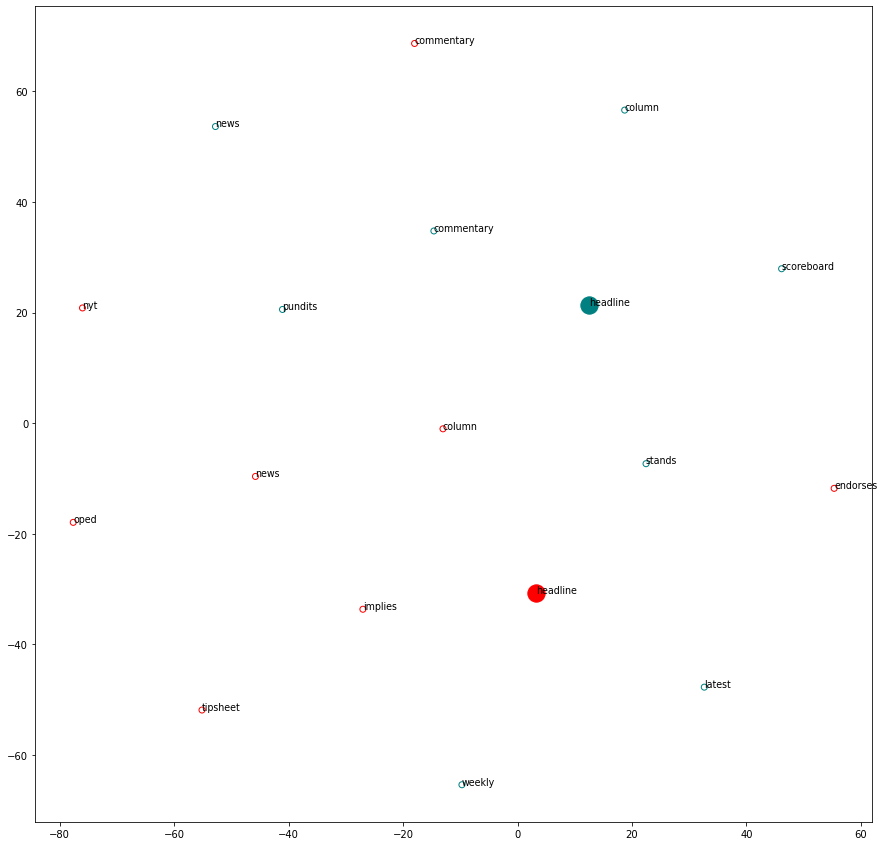

In [19]:
def get_top_n_plus_ties(arr, n):
    sorted_args = np.argsort(-arr)
    thresh = arr[sorted_args[n]]
    n_ = np.sum(arr >= thresh)
    return sorted_args[:n_]
def get_most_similar(word, W, n):
    b = W[vocab[word]]
    cs = W.dot(b) / (np.linalg.norm(W, axis=1) * np.linalg.norm(b))
    return get_top_n_plus_ties(cs, n)
def create_words_plot(embed1, embed2, WORD, k=9):
    ids1 = get_most_similar(WORD, embed1, k-1)
    ids2 = get_most_similar(WORD, embed2, k-1)
    words1 = [id2word[i] for i in ids1]
    words2 = [id2word[i] for i in ids2]
    v = TSNE(n_components=2,random_state=RANDOM_SEED).fit_transform(
        np.concatenate([embed1[ids1],embed2[ids2]]))
    fig = plt.figure(figsize=(15,15))
    plt.scatter(v[:k,0],v[:k,1],facecolors='none',edgecolors='teal')
    plt.scatter(v[k:,0],v[k:,1],facecolors='none',edgecolors='red')
    for i, word in enumerate(words1):
        plt.annotate(word,(v[i,0],v[i,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i,0],v[i,1],c='teal',s=300)
    for i, word in enumerate(words2):
        plt.annotate(word,(v[i+k,0],v[i+k,1]),size=9.5)
        if word == WORD:
            plt.scatter(v[i+k,0],v[i+k,1],c='red',s=300)
create_words_plot(text_embed,title_embed,'headline')